In [1]:
# core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn

# functional
import pickle
from itertools import product
from functools import partial
from torch.multiprocessing import Pool, set_start_method

# custom
from scripts.functions import tune_rnn

# warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
try:
    set_start_method('spawn')
except RuntimeError as e:
    print("The start method has already been set.")

## Load in Data

In [3]:
data_names = ['bert_train', 'bert_test', 'y_train_binary', 'y_test_binary'] # 'tfidf_train', 'tfidf_test', 

for var_name in data_names:
    with open(f'data/{var_name}.pkl', 'rb') as f:
        globals()[var_name] = pickle.load(f)

## Hyperparameter Tuning

In [4]:
Adam = torch.optim.Adam
SGD = torch.optim.SGD
RMSprop = torch.optim.RMSprop

hp_space = {
    '0_hidden_size': [50, 100, 150],
    '1_num_layers': [1, 2, 3],
    '2_dropout': [0, 0.25, 0.5],
    '3_batch_size': [64, 128, 256],
    '4_optimizer': [Adam, SGD, RMSprop],
    '5_learning_rate': [0.001, 0.01, 0.1]
}

hp_combos = list(product(*hp_space.values()))

len(hp_combos)

729

In [5]:
# tune_rnn_accuracy = partial(
#     tune_rnn, 
#     X_train = tfidf_train, X_test = tfidf_test, 
#     y_train = y_train_binary.unsqueeze(1), 
#     y_test = y_test_binary.unsqueeze(1), 
#     metric = accuracy_score
# )

# tune_rnn_precision = partial(
#     tune_rnn, 
#     X_train = tfidf_train, X_test = tfidf_test, 
#     y_train = y_train_binary.unsqueeze(1), 
#     y_test = y_test_binary.unsqueeze(1), 
#     metric = precision_score
# )

# tune_rnn_recall = partial(
#     tune_rnn, 
#     X_train = tfidf_train, X_test = tfidf_test, 
#     y_train = y_train_binary.unsqueeze(1), 
#     y_test = y_test_binary.unsqueeze(1), 
#     metric = recall_score
# )

# tune_rnn_f1 = partial(
#     tune_rnn, 
#     X_train = tfidf_train, X_test = tfidf_test, 
#     y_train = y_train_binary.unsqueeze(1), 
#     y_test = y_test_binary.unsqueeze(1), 
#     metric = f1_score
# )

In [6]:
tune_rnn_accuracy = partial(
    tune_rnn, 
    X_train = bert_train, X_test = bert_test, 
    y_train = y_train_binary.unsqueeze(1), 
    y_test = y_test_binary.unsqueeze(1), 
    metric = accuracy_score
)

tune_rnn_precision = partial(
    tune_rnn, 
    X_train = bert_train, X_test = bert_test, 
    y_train = y_train_binary.unsqueeze(1), 
    y_test = y_test_binary.unsqueeze(1), 
    metric = precision_score
)

tune_rnn_recall = partial(
    tune_rnn, 
    X_train = bert_train, X_test = bert_test, 
    y_train = y_train_binary.unsqueeze(1), 
    y_test = y_test_binary.unsqueeze(1), 
    metric = recall_score
)

tune_rnn_f1 = partial(
    tune_rnn, 
    X_train = bert_train, X_test = bert_test, 
    y_train = y_train_binary.unsqueeze(1), 
    y_test = y_test_binary.unsqueeze(1), 
    metric = f1_score
)

In [7]:
with Pool(processes = 12) as pool:
    results_accuracy = pool.map(tune_rnn_accuracy, hp_combos)

best_result_idx = results_accuracy.index(max(results_accuracy))
best_hps_accuracy = hp_combos[best_result_idx]
best_hps_accuracy = dict(zip(hp_space.keys(), best_hps_accuracy))

best_hps_accuracy

{'0_hidden_size': 50,
 '1_num_layers': 1,
 '2_dropout': 0.5,
 '3_batch_size': 256,
 '4_optimizer': torch.optim.rmsprop.RMSprop,
 '5_learning_rate': 0.001}

In [8]:
with Pool(processes = 12) as pool:
    results_precision = pool.map(tune_rnn_precision, hp_combos)

best_result_idx = results_precision.index(max(results_precision))
best_hps_precision = hp_combos[best_result_idx]
best_hps_precision = dict(zip(hp_space.keys(), best_hps_precision))

best_hps_precision

{'0_hidden_size': 50,
 '1_num_layers': 3,
 '2_dropout': 0,
 '3_batch_size': 64,
 '4_optimizer': torch.optim.sgd.SGD,
 '5_learning_rate': 0.001}

In [9]:
with Pool(processes = 12) as pool:
    results_recall = pool.map(tune_rnn_recall, hp_combos)

best_result_idx = results_recall.index(max(results_recall))
best_hps_recall = hp_combos[best_result_idx]
best_hps_recall = dict(zip(hp_space.keys(), best_hps_recall))

best_hps_recall

{'0_hidden_size': 50,
 '1_num_layers': 1,
 '2_dropout': 0,
 '3_batch_size': 64,
 '4_optimizer': torch.optim.rmsprop.RMSprop,
 '5_learning_rate': 0.1}

In [10]:
with Pool(processes = 12) as pool:
    results_f1 = pool.map(tune_rnn_f1, hp_combos)

best_result_idx = results_f1.index(max(results_f1))
best_hps_f1 = hp_combos[best_result_idx]
best_hps_f1 = dict(zip(hp_space.keys(), best_hps_f1))

best_hps_f1

{'0_hidden_size': 150,
 '1_num_layers': 1,
 '2_dropout': 0,
 '3_batch_size': 128,
 '4_optimizer': torch.optim.rmsprop.RMSprop,
 '5_learning_rate': 0.1}

In [11]:
best_hps = [best_hps_accuracy, best_hps_precision, best_hps_recall, best_hps_f1]
results = [results_accuracy, results_precision, results_recall, results_f1]
metrics = ['accuracy', 'precision', 'recall', 'f1']

for result, metric in zip(results, metrics):
    with open(f'data/hp_result_{metric}.pkl', 'wb') as f:
        pickle.dump(result, f)

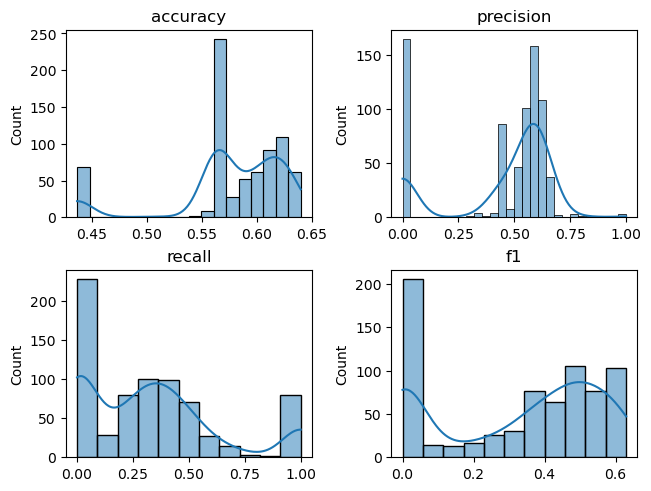

In [12]:
fig, axes = plt.subplots(2, 2, layout = 'constrained')

for result, metric, ax in zip(results, metrics, axes.ravel()):
    sns.histplot(result, ax = ax, kde = True)
    ax.set_title(metric)

plt.show()

In [13]:
results_df = pd.DataFrame(hp_combos, columns = hp_space.keys())

for result, metric in zip(results, metrics):
    results_df[metric] = result

results_df['4_optimizer'] = results_df['4_optimizer'].apply(lambda x: x.__name__)

results_df

,0_hidden_size,1_num_layers,2_dropout,3_batch_size,4_optimizer,5_learning_rate,accuracy,precision,recall,f1
0,50,1,0.0,64,Adam,0.001,0.601421,0.605016,0.401447,0.494359
1,50,1,0.0,64,Adam,0.010,0.584057,0.586957,0.354430,0.500505
2,50,1,0.0,64,Adam,0.100,0.563536,0.000000,0.000000,0.000000
3,50,1,0.0,64,SGD,0.001,0.561957,0.531381,0.065099,0.312336
4,50,1,0.0,64,SGD,0.010,0.605367,0.575251,0.215190,0.371532
...,...,...,...,...,...,...,...,...,...,...
724,150,3,0.5,256,SGD,0.010,0.565114,0.576923,0.012658,0.035336
725,150,3,0.5,256,SGD,0.100,0.602999,0.590206,0.370705,0.368159
726,150,3,0.5,256,RMSprop,0.001,0.629834,0.623596,0.122966,0.447277
727,150,3,0.5,256,RMSprop,0.010,0.563536,0.436464,1.000000,0.000000


------------accuracy------------


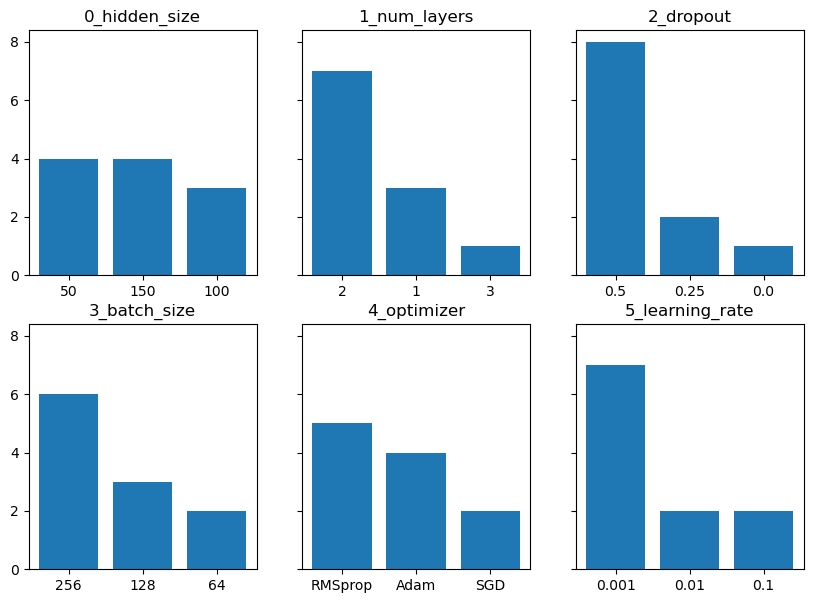






------------precision------------


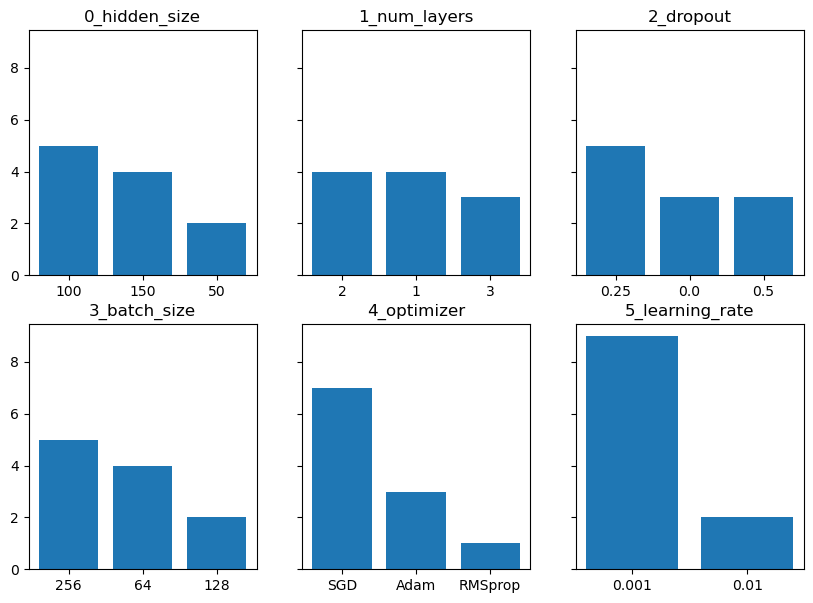






------------recall------------


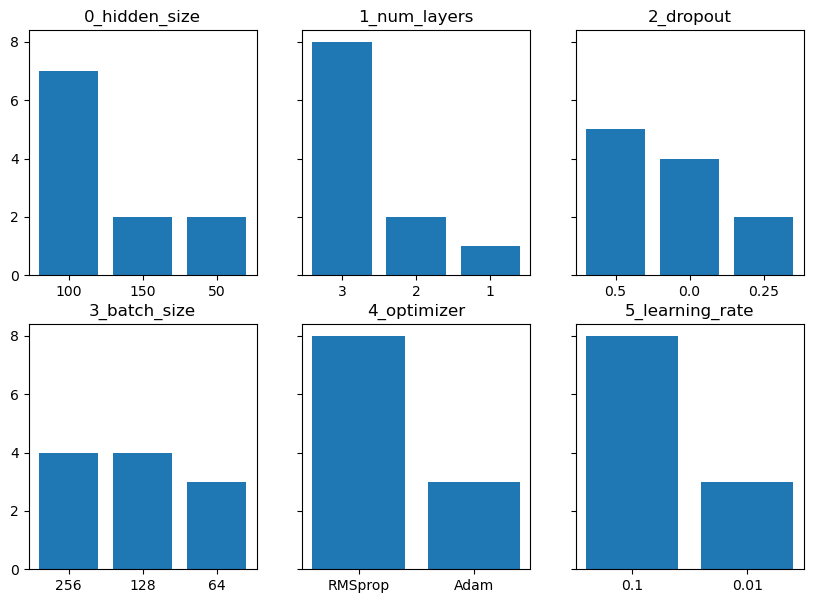






------------f1------------


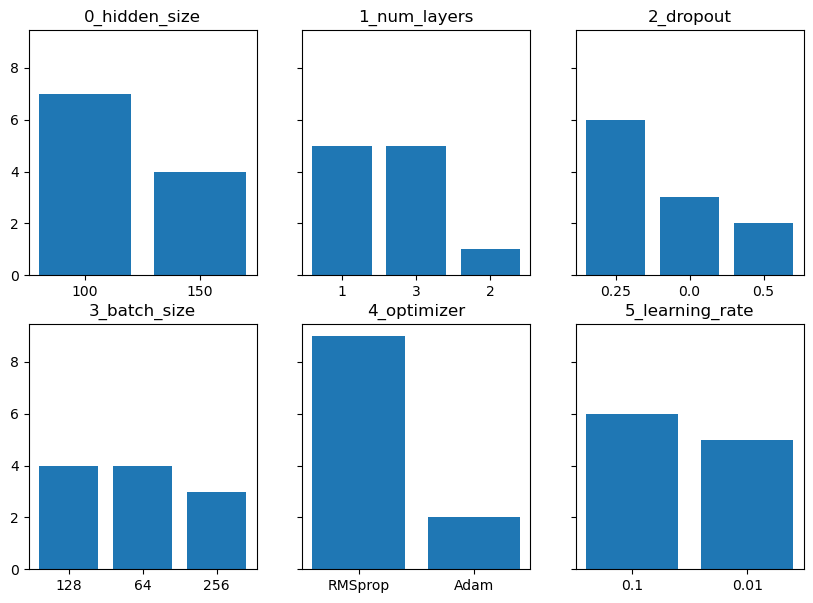

In [14]:
for metric in metrics:
    top10 = results_df.sort_values(by = metric, ascending = False, ignore_index = True).iloc[0:11,:]
    print(f'------------{metric}------------')
    fig, axes = plt.subplots(2, 3, figsize = (10, 7), sharey = True)
    for hp, ax in zip(hp_space.keys(), axes.ravel()):
        ax.bar(
            [str(x) for x in top10[hp].value_counts().index.values],
            top10[hp].value_counts().values
        )
        ax.set_title(hp)
        ax.set_xlabel('')
    plt.show()
    print(f'\n\n\n\n')

In [17]:
results_df.sort_values(by = 'f1', ascending = False, ignore_index = True).head(20)

,0_hidden_size,1_num_layers,2_dropout,3_batch_size,4_optimizer,5_learning_rate,accuracy,precision,recall,f1
0,150,1,0.00,128,RMSprop,0.10,0.510655,0.000000,1.000000,0.629787
1,100,1,0.25,128,RMSprop,0.01,0.609313,0.000000,0.768535,0.626097
2,150,1,0.50,64,Adam,0.01,0.602210,0.534060,0.499096,0.619698
3,100,2,0.00,64,Adam,0.01,0.633781,0.520833,0.484629,0.614342
4,100,1,0.00,64,RMSprop,0.10,0.563536,0.000000,1.000000,0.613428
5,150,1,0.25,64,RMSprop,0.10,0.563536,0.496711,1.000000,0.612555
6,100,3,0.25,256,RMSprop,0.10,0.563536,0.000000,0.000000,0.607692
7,100,3,0.25,256,RMSprop,0.01,0.436464,0.000000,0.000000,0.607692
8,100,3,0.25,128,RMSprop,0.10,0.436464,0.436464,0.000000,0.607692
9,150,3,0.50,256,RMSprop,0.10,0.436464,0.436464,1.000000,0.607692
